In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的Qwen API Key，评估用
%env TAVILY_API_KEY=tvly-替换为自己的Tavily API Key，检索外部知识用

In [3]:
%%capture --no-stderr
!pip install -U langchain langchain-community langchain-openai langchain_chroma pypdf sentence_transformers chromadb shutil openpyxl FlagEmbedding

In [4]:
import os
import pandas as pd

In [5]:
expr_version = 'retrieval_v14_crag'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 为知识库构建索引

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [10]:
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

# CRAG

## State定义

In [11]:
from typing import Dict, TypedDict

class GraphState(TypedDict):
    """
    Represents the state of an agent in the conversation.

    Attributes:
        keys: A dictionary where each key is a string and the value is expected to be a list or another structure
              that supports addition with `operator.add`. This could be used, for instance, to accumulate messages
              or other pieces of data throughout the graph.
    """

    keys: Dict[str, any]

## Nodes和Edges定义

### Nodes

In [12]:
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain.llms import Ollama

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, documents, that contains documents.
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    retriever = vector_db.as_retriever(search_kwargs={'k': 3})
    documents = retriever.invoke(question)
    return {"keys": {"documents": documents, "question": question}}

/opt/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [32]:
import time

def rag(query, llm, documents=None, n_chunks=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    if documents is None:
        chunks = vector_db.similarity_search(query, k=n_chunks)
    else:
        chunks = documents
        
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)

    if not isinstance(resp, str):
        resp = resp.content
    
    return resp, chunks

In [14]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, generation, that contains generation.
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # LLM
    # llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, streaming=True)
    llm = Ollama(
        model='qwen2:7b-instruct',
        base_url='http://localhost:11434'
    )
    generation, documents = rag(question, llm, documents)
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }

In [15]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, filtered_documents, that contains relevant documents.
    """

    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)
    
    # LLM
    # model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    # LLM with tool and enforce invocation
    # 这个是使用gpt-4模型时的工具绑定方法
    # llm_with_tool = model.bind(
    #     tools=[convert_to_openai_tool(grade_tool_oai)],
    #     tool_choice={"type": "function", "function": {"name": "grade"}},
    # )
    
    model = OllamaFunctions(
        model='qwen2:7b-instruct-32k',
        base_url='http://localhost:11434',
        format='json'
    )
    """
    convert_to_openai_tool(grade_tool_oai)的数据结构如下，但我们只需要function部分
    {'type': 'function',
     'function': {'name': 'grade',
      'description': 'Binary score for relevance check.',
      'parameters': {'type': 'object',
       'properties': {'binary_score': {'description': "Relevance score 'yes' or 'no'",
         'type': 'string'}},
       'required': ['binary_score']}}}
    """
    llm_with_tool = model.bind_tools(
        tools=[convert_to_openai_tool(grade_tool_oai)['function']],
        function_call={"name": "grade"},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool | parser_tool

    # Score
    filtered_docs = []
    search = "No"  # Default do not opt for web search to supplement retrieval
    for d in documents:
        score = chain.invoke({"question": question, "context": d.page_content})
        grade = score[0].binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            search = "Yes"  # Perform web search
            continue

    return {
        "keys": {
            "documents": filtered_docs,
            "question": question,
            "run_web_search": search,
        }
    }

这面这段代码涉及到函数调用，如果执行出错，可以把核心部分提取出来进行调试

In [16]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

model = OllamaFunctions(
    model='qwen2:7b-instruct-32k',
    # model='qwen2.5:7b',
    base_url='http://localhost:11434',
    format='json'
)

# 使用OllamaFunctions时会警告建议使用ChatOllama，但ChatOllama不支持函数调用
# from langchain_ollama import ChatOllama
# model = ChatOllama(
#     model='qwen2:7b-instruct-32k',
#     base_url='http://localhost:11434',
#     format='json'
# )

class grade(BaseModel):
    """Binary score for relevance check."""

    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

grade_tool_oai = convert_to_openai_tool(grade)
llm_with_tool = model.bind_tools(
    tools=[convert_to_openai_tool(grade_tool_oai)['function']],
    function_call={"name": "grade"},
)

# Parser
parser_tool = PydanticToolsParser(tools=[grade])

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {context} \n\n
    Here is the user question: {question} \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
    input_variables=["context", "question"],
)

# Chain
chain = prompt | llm_with_tool | parser_tool

print(convert_to_openai_tool(grade_tool_oai))

{'type': 'function', 'function': {'name': 'grade', 'description': 'Binary score for relevance check.', 'parameters': {'type': 'object', 'properties': {'binary_score': {'description': "Relevance score 'yes' or 'no'", 'type': 'string'}}, 'required': ['binary_score']}}}


/tmp/ipykernel_3999598/2245898911.py:3: LangChainDeprecationWarning: The class `OllamaFunctions` was deprecated in LangChain 0.0.64 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  model = OllamaFunctions(


In [17]:
(prompt | llm_with_tool).invoke({
    'question': '报告的时间是什么时候', 
    'context': splitted_docs[0].page_content
})

AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-3b14c663-2f63-483e-b370-0c1363daca63-0', tool_calls=[{'name': 'grade', 'args': {'binary_score': 'yes'}, 'id': 'call_0cf57bc7cd434a7ca05a93ae8614acf9', 'type': 'tool_call'}])

从结果看，触发了函数调用

In [18]:
(prompt | llm_with_tool | parser_tool).invoke({
    'question': '报告的时间是什么时候', 
    'context': splitted_docs[0].page_content
})

[grade(binary_score='yes')]

In [19]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New value saved to question.
    """

    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Please keep the generated question in the same language as the initial question. \n
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question: """,
        input_variables=["question"],
    )

    # Grader
    # model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    model = Ollama(
        model='qwen2:7b-instruct',
        base_url='http://localhost:11434'
    )
    
    # Prompt
    chain = prompt | model | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {"keys": {"documents": documents, "question": better_question}}

使用Tavily进行搜索

In [20]:
def web_search(state):
    """
    Web search using Tavily.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        state (dict): Web results appended to documents.
    """

    print("---WEB SEARCH---")
    
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    print(f"question: {question}")
    
    tool = TavilySearchResults()
    docs = tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"keys": {"documents": documents, "question": question}}

### Edges

In [21]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        dict: New key added to state, filtered_documents, that contains relevant documents.
    """

    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]
    search = state_dict["run_web_search"]

    if search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

## Graph定义

In [22]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

/opt/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:547: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
/opt/anaconda3/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:547: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


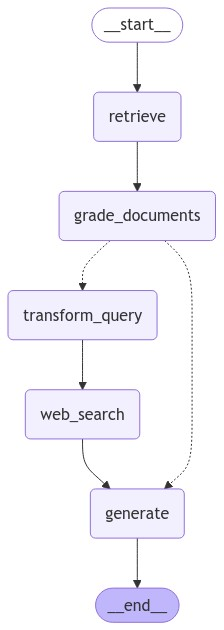

In [45]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## 测试一下

模拟答案在知识库内的情况

In [23]:
inputs = {"keys": {"question": "报告的时间是什么时候?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---RETRIEVE---
"Output from node 'retrieve':"
'---'
{ 'documents': [ Document(metadata={'page': 50, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'edf68bd0-d507-4739-a4d4-b2e87215b655'}, page_content='全球经济金融展望报告\n中国银行研究院 49 2024年\n场仍处于下行周期的早期阶段。基于历史经验，叠加长期结构性因素，商业房\n地产的此轮下行周期可能持续更长时间。第四，美国大型银行更具有能力抵御\n严重衰退和房地产市场萎缩的冲击，而中小型银行面临的损失可能更大。'),
                 Document(metadata={'page': 33, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': '3e312dfa-dd43-4ab9-961f-a2e442c89cdd'}, page_content='全球经济金融展望报告\n中国银行研究院 32 2024年\n图19：美国联邦基金目标利率与全球MSCI指数\n资料来源：Wind，中国银行研究院\n表3：全球主要股指概览\n注：涨跌幅区间为2023年1月1日至2023年11月15日，收盘价和市盈\n率为2023年11月15日。\n资料来源：Wind，中国银行研究院'),
                 Document(metadata={'page': 0, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'e73a0c9d-d42b-4350-a4c3-b38bf67c68a5'}, page_content='研究院\n全球经济金融展望报告\n要点2024年年报（总第57期） 报告日期：2023年12月12日\n●2023年全球经济增长动力持续回落，各国复苏分化，\n发达经济体增速明显放缓，新兴经济体整体表现稳定。\n全球贸易增长乏力，各国生产景气度逐渐回落，内需\n对经济的拉动作用减弱。欧美央行货币政策紧缩态势\n放缓，美元指数高位震荡后走弱，全球股市表现总体\n好于预期，但区域分化明显。高利率环境抑制债券融\

/tmp/ipykernel_3999598/3884634306.py:18: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(


"Output from node 'generate':"
'---'
{ 'documents': [ Document(metadata={'page': 50, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'edf68bd0-d507-4739-a4d4-b2e87215b655'}, page_content='全球经济金融展望报告\n中国银行研究院 49 2024年\n场仍处于下行周期的早期阶段。基于历史经验，叠加长期结构性因素，商业房\n地产的此轮下行周期可能持续更长时间。第四，美国大型银行更具有能力抵御\n严重衰退和房地产市场萎缩的冲击，而中小型银行面临的损失可能更大。'),
                 Document(metadata={'page': 33, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': '3e312dfa-dd43-4ab9-961f-a2e442c89cdd'}, page_content='全球经济金融展望报告\n中国银行研究院 32 2024年\n图19：美国联邦基金目标利率与全球MSCI指数\n资料来源：Wind，中国银行研究院\n表3：全球主要股指概览\n注：涨跌幅区间为2023年1月1日至2023年11月15日，收盘价和市盈\n率为2023年11月15日。\n资料来源：Wind，中国银行研究院'),
                 Document(metadata={'page': 0, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'e73a0c9d-d42b-4350-a4c3-b38bf67c68a5'}, page_content='研究院\n全球经济金融展望报告\n要点2024年年报（总第57期） 报告日期：2023年12月12日\n●2023年全球经济增长动力持续回落，各国复苏分化，\n发达经济体增速明显放缓，新兴经济体整体表现稳定。\n全球贸易增长乏力，各国生产景气度逐渐回落，内需\n对经济的拉动作用减弱。欧美央行货币政策紧缩态势\n放缓，美元指数高位震荡后走弱，全球股市表现总体\n好于预期，但区域分化明显。高利率环境抑制债券融\n资需求，债券违约风险持续上升

查看最终答案

In [24]:
output['generate']['keys']['generation']

'2023年12月12日'

模拟答案不在知识库范围的情况

In [25]:
def demo():
    inputs = {"keys": {"question": "2024年美国总统大选结果是什么，谁赢得了竞选?"}}
    for output in app.stream(inputs):
        for key, value in output.items():
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint.pprint("\n---\n")

这部分不稳定，加个重试

In [26]:
max_retries = 3
while max_retries > 0:
    try:
        demo()
        break
    except Exception as e:
        max_retries -= 1
        print(f"error: {e}, max_retries={max_retries}")

---RETRIEVE---
"Output from node 'retrieve':"
'---'
{ 'documents': [ Document(metadata={'page': 34, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'dc18ddce-a123-45b5-86e2-2ff1378fb6aa'}, page_content='全球经济金融展望报告\n中国银行研究院 33 2024年\n展望2024年，全球股票市场走势将呈现以下特征。\n1.美国股票市场上行空间有限，新兴经济体股市值得关注\n2024年，受美国通胀回落、美联储暂停加息以及企业盈利能力稳步提升等\n因素支撑，美国股票市场将呈现上扬态势。但考虑到美股股价虚高等因素，后\n续美股上行空间相对有限。新兴经济体稳步复苏，未来反弹空间值得期待。\n2.科技股仍是投资热点，绿色能源受到投资青睐\n2024年，全球股市将延续由科技股领涨的结构性行情。截至2023年11月\n15日，信息科技MSCI指数涨幅高达41.1%，远高于电信业务（31.5%）、非日\n常消费品（21.5%）等板块（图20）。其中，以人工智能、大数据等新兴行业为\n代表的科技公司或将受到广泛关注。随着企业盈利能力逐渐增强以及科技水平\n不断发展，科技股依然是投资者热衷的板块。此外，在全球投资者绿色环保意\n识显著增强的背景下，绿色能源板块崛起或成为全球股市投资者关注的亮点。\n图20：全球MSCI一级行业指数涨跌幅（%）\n注：涨跌幅区间为2023年1月1日至2023年11月15日，收盘价和市盈\n率为2023年11月15日。\n资料来源：Wind，中国银行研究院'),
                 Document(metadata={'page': 11, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': '0943b71a-7314-4cef-a7d9-682c7ddc9d7f'}, page_content='全球经济金融展望报告\n中国银行研究院 10 2024年\n模下降2.5%，进口降幅大于出口，带动贸易赤字收窄12.1%。\n图8：各分项对美国GDP环比增长折年率的季度拉动率变化趋势（%）\n资料来源：Wind，中国

如果只想获取答案，可以调用invoke方法

In [27]:
# output = app.invoke(inputs)

# 生成答案

In [28]:
llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    top_k=1
)

In [29]:
import time

def crag(question, max_retries=3):
    inputs = {"keys": {"question": question}}
    while max_retries > 0:
        try:
            output = app.invoke(inputs)
            return output['keys']['generation']
        except Exception as e:
            max_retries -= 1
            print(f"error: {e}, sleeping 2s, {max_retries} retries left")
            time.sleep(2)
    # 使用之前的流程兜底
    return rag(question, llm)[0]

In [30]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer = crag(question)
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer
        }
        
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])

    return prediction_df

In [ ]:
pred_df = predict(prediction_df)

  0%|          | 0/100 [00:00<?, ?it/s]

---RETRIEVE---
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
---RETRIEVE---
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
---RETRIEVE---
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
---RETRIEVE---
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
---RETRIEVE---
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
---RETRIEVE---
---CHECK R

In [34]:
save_path = os.path.join(expr_dir, 'pred_df.xlsx')
pred_df.to_excel(save_path, index=False)

# 评估

In [35]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        if not isinstance(gen_answer, str):
            gen_answer = gen_answer.content
        gen_answer = str(gen_answer)
        
        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [38]:
pred_df['raw_score'] = evaluate(pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
pred_df['raw_score'].unique()

array(['是', '否',
       '否\n\n实际上，美国金融危机风险指标并没有一个统一的英文缩写为ROFCI。常见的金融危机风险指标包括金融压力指数（Financial Stress Index, FSI）、脆弱性指标（Vulnerability Indicator, VI）等。ROFCI并不是一个广泛认可的缩写。'],
      dtype=object)

In [40]:
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)

In [41]:
pred_df['score'].mean()

0.45

In [42]:
save_path = os.path.join(expr_dir, 'eval_df.xlsx')
pred_df.to_excel(save_path, index=False)